In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn 
import os
import matplotlib.pyplot as plt
import matplotlib
import cooltools
import cooler
from NGS import HiCTools as HT
import pyBigWig
from scipy.stats import mannwhitneyu
import matplotlib.colors as cl
from typing import Callable
import bbi
from typing import Tuple

# Define functions

In [2]:
def loadBwBins(fileP, binFrame):
    """Calculate average signal in bw-file inside
    the bins (start, end) specified in bins on the chromosome chrom."""
    with pyBigWig.open(fileP) as bw:
        meanList = []
        for binID in binFrame.iterrows():
            chrom = binID[1]["chrom"]
            start = binID[1]["start"]
            end = binID[1]["end"]
            try:
                mean = bw.stats(chrom, start, end)[0]
                meanList.append(mean)
            except RuntimeError:
                meanList.append(np.nan)
    outputFrame = binFrame.copy()
    outputFrame.loc[:, "value"] = meanList
    return outputFrame

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow + 1)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow), i:(i+halfWindow)]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow),)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))

# Define plotting parameters
This will make pdfs include text as fields, not as single characters

In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42

# Set Wd

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004812/")

# Plot chromatin enrichment for Top TADs

## Load in data
This is LOLA extended enrichment data for the top 10% TADs (trans-sister contacts)

In [5]:
topTADsChrom = pd.read_csv("./Results/LOLA_PairingDomains/LOLA_EXT/userSet_TopTADs.tsv", sep="\t").replace(np.inf, np.nan)

HeLa cells have ID 117 on the roadmap epigenomics project

In [6]:
topHeLaChrom = topTADsChrom.loc[[True if "117" in i.upper() else False for i in topTADsChrom["filename"]], :].sort_values(by="pValueLog", ascending=True)
topHeLaChrom.loc[:, "rank"] = range(len(topHeLaChrom))

## Add pseudocount to bars to make bars with -log10(1) visible

In [7]:
topHeLaChrom["pValueLog"] = topHeLaChrom["pValueLog"] + 0.05

## Rename xlabel to make them readable

In [8]:
topHeLaChrom.loc[:, "LabelNice"] = [i.split("-")[1].split(".")[0] if "H2A.Z" not in i else "H2A.Z" for i in topHeLaChrom["filename"]]

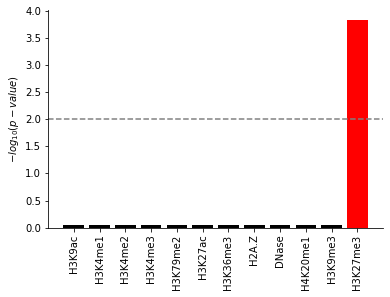

In [9]:
f, ax = plt.subplots()
ax.bar(topHeLaChrom["rank"], topHeLaChrom["pValueLog"], color="black")
# draw the top bar in red
ax.bar(topHeLaChrom.loc[topHeLaChrom["rank"] == np.max(topHeLaChrom["rank"]), "rank"], topHeLaChrom.loc[topHeLaChrom["rank"] == np.max(topHeLaChrom["rank"]), "pValueLog"], color="red")
ax.axhline(y=2, color="grey", ls="--")
ax.set(ylabel="$-log_{10}(p-value)$")
# name xlabels
plt.xticks(topHeLaChrom["rank"], topHeLaChrom["LabelNice"], rotation=90)
#f.set_size_inches(5, 5)
sbn.despine()
plt.show()

## Write to file

In [10]:
resultsdir = "./Results/LOLA_PairingDomains"
f.savefig(os.path.join(resultsdir, "TopTads_enrichment_Chromatin_barplot.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "TopTads_enrichment_Chromatin_barplot.pdf"), bbox_inches="tight")

# Calculate chip-seq enrichment of H3K27me3 at TopTADs

## Load in coolers

In [11]:
HICPATH = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Load  in TADs

In [12]:
tads = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tads.columns = ["chrom", "start", "end"]
tads.loc[:, "ID"] = range(len(tads))

## Get chromosomal arms

In [13]:
arms = HT.getArmsHg19()

## Assign regions

In [14]:
regionsAnnotated = cooltools.snipping.assign_regions(tads,  list(arms.itertuples(index=False, name=None))).dropna()

## Extract averagte cis- and trans-sister-contacts for TADs

In [15]:
# extract average Values of TADs
cisAverage = []
transAverage = []

for index, row in enumerate(regionsAnnotated.iterrows()):
    if index % 1000 == 0:
        print(index)
    try:
        # get out cis-matrix with the exact boundary
        cisTemp = clrs["cis"].matrix(balance=True).fetch(f"{row[1].chrom}:{row[1].start}-{row[1].end}")
        # blank out diagonal
        cisTemp[np.diag_indices_from(cisTemp)] = np.nan
        # get out trans-matrix with the exact boundary
        transTemp = clrs["trans"].matrix(balance=True).fetch(f"{row[1].chrom}:{row[1].start}-{row[1].end}")
        # blank out diagonal
        transTemp[np.diag_indices_from(transTemp)] = np.nan
        cisAverage.append(np.nanmean(cisTemp))
        transAverage.append(np.nanmean(transTemp))
    except ValueError:
        cisAverage.append(np.nan)
        transAverage.append(np.nan)

0
1000
2000
3000
4000
5000


## Plot distribution of pairing score and visualize cut-off

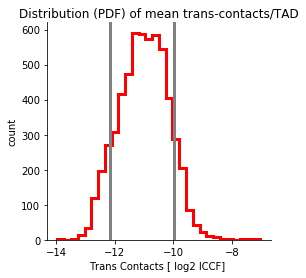

In [17]:
# calculate log2 of average
averageTrans = np.log2(np.array(transAverage))
averageTrans[np.isinf(averageTrans)] = np.nan
# define cut-offs
thUp = np.percentile(averageTrans[~np.isnan(averageTrans)], 90)
thDown = np.percentile(averageTrans[~np.isnan(averageTrans)], 10)

f, ax = plt.subplots()
ax.hist(averageTrans, bins=30, histtype="step", label="trans", lw=3, color="red")
ax.axvline(thUp, color="grey", lw=3)
ax.axvline(thDown, color="grey", lw=3)
ax.set(title="Distribution (PDF) of mean trans-contacts/TAD", xlabel="Trans Contacts [ log2 ICCF] ", ylabel="count")
sbn.despine()
f.set_size_inches(4, 4)
plt.show()

## Write to file

In [17]:
f.savefig(os.path.join(resultsdir, "PairingScoreDist_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "PairingScoreDist_trans.pdf"), bbox_inches="tight")

# Plot distribution of H3K27me3 of the different Classes

## Classify TADs based on trans-sister amounts

In [18]:
# Annotate TADs with average tans-amount

regionsAnnotated.loc[:, "transAmount"] = averageTrans

transClass = []
for i in regionsAnnotated["transAmount"]:
    if i >= thUp:
        transClass.append("Top")
    elif i <= thDown:
        transClass.append("Bottom")
    else:
        transClass.append("Middle")

regionsAnnotated.loc[:, "transClass"] = transClass

## Annotate with amount of H3K27me3

In [19]:
fileP = "/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_analysis/genomicFeatures/GSM2769893_K27me3-H4-A_-11.FCHJMLGBBXX_L6_R1_IGGCTACAG.PE.U12.dedup.s1.bam.s20_total_based_norm.bigwig"
controlP = "/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_analysis/genomicFeatures/GSM2769883_1_pct_input-3.FCHJMLGBBXX_L6_R1_ITTAGGCAT.PE.U12.dedup.s1.bam.s20_total_based_norm.bigwig"
k27Values = loadBwBins(fileP, regionsAnnotated)
controlValues = loadBwBins(controlP, regionsAnnotated)

## Normalize to control

In [20]:
k27Values.loc[:, "value"] = k27Values["value"]/controlValues["value"]

## Plot result for top and bottom TADs

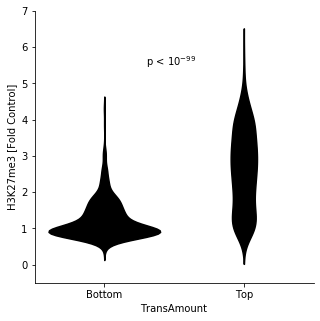

In [21]:
TopAmounts = k27Values.loc[k27Values["transClass"] == "Top", "value"]
BottomAmounts = k27Values.loc[k27Values["transClass"] == "Bottom", "value"]

s, p = mannwhitneyu(TopAmounts, BottomAmounts)

orderOfMag = int(np.log10(p))

f, ax = plt.subplots()
sbn.violinplot(x="transClass", y="value", data=k27Values.loc[k27Values["transClass"].isin(["Top", "Bottom"])], inner=None, color="black")
ax.text(0.4, 0.8, f"p < $10^{{{orderOfMag}}}$", transform=ax.transAxes)
ax.set(ylim=(-0.5, 7), xlabel="TransAmount", ylabel="H3K27me3 [Fold Control]")
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

## Save to file

In [22]:
f.savefig(os.path.join(resultsdir, "H3K27me_amount_transBins.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "H3K27me3_amount_transBins.pdf"), bbox_inches="tight")

# Plot 1d lineprofile plot of high and bottom TADs

## Get cooler for 20kb binsize

In [19]:
BINSIZE = 20000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Get genome wide distribution of pairing score

In [20]:
genomeWidePairingScore = getPairingScore(clrs["trans"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]

In [21]:
genomeWidePairingScoreCis = getPairingScore(clrs["cis"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]

In [22]:
genomeWidePairing = {}
genomeWidePairing["cis"] = genomeWidePairingScoreCis
genomeWidePairing["trans"] = genomeWidePairingScore

## Extract individual windows

In [23]:
regionsAnnotated.loc[:, "size"] = regionsAnnotated["end"] - regionsAnnotated["start"]
regionsAnnotated.loc[:, "mid"] = (regionsAnnotated["end"] + regionsAnnotated["start"])//2

In [24]:
regionsHigh = regionsAnnotated.loc[regionsAnnotated["transClass"] == "Top", :]
regionsLow = regionsAnnotated.loc[regionsAnnotated["transClass"] == "Bottom", :]

In [25]:
windowsHigh = HT.assignRegions(3000000, 20000, regionsHigh["chrom"], regionsHigh["mid"], arms).dropna()

In [26]:
pileupIndICCFHigh = {interType: HT.doPileupICCF(clrs[interType], windowsHigh, collapse=False)
                 for interType in ["cis", "trans"]}

In [27]:
windowsLow = HT.assignRegions(3000000, 20000, regionsLow["chrom"], regionsLow["mid"], arms).dropna()

In [28]:
pileupIndICCFLow = {interType: HT.doPileupICCF(clrs[interType], windowsLow, collapse=False)
                 for interType in ["cis", "trans"]}

## High TAD sliding diamond along windows

In [29]:
high1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFHigh[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    high1dICCF[rType] = pd.concat(tempList)

0
0


## Prepare profiles for plotting

In [30]:
regionsHigh.loc[:, "ID"] = range(len(regionsHigh))

In [31]:
sortedSizeHigh = regionsHigh.sort_values(by="size", ascending=True)["ID"]

In [32]:
highResult = {}
for rType in ["cis", "trans"]:
    temp = high1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeHigh,:].dropna(axis=0, how="all")
    highResult[rType] = tempExp

## Plot results

# Normalize to median and plot std

In [33]:
normDictHigh = {}
for rType in ["cis", "trans"]:
    temp = highResult[rType]
    temp = temp - np.nanmedian(genomeWidePairing[rType])
    temp = temp/np.nanstd(genomeWidePairing[rType])
    normDictHigh[rType] = temp

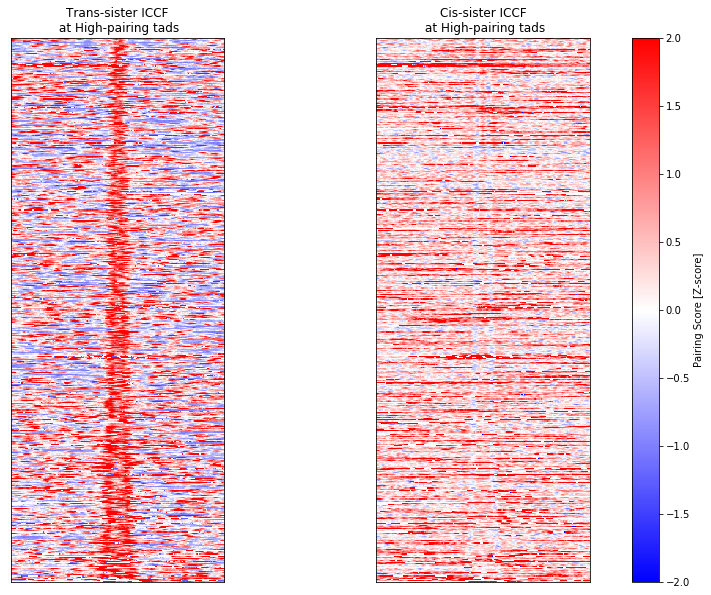

In [34]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictHigh["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictHigh["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at High-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at High-pairing tads")
f.colorbar(im, ax=ax, label="Pairing Score [Z-score]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

## Write to file

In [39]:
f.savefig(os.path.join(resultsdir, "High_pairing_TADs_line_profile.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "High_pairing_TADs_line_profile.pdf"), bbox_inches="tight")

## Low TADs

In [35]:
low1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFLow[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    low1dICCF[rType] = pd.concat(tempList)

0
0


In [36]:
regionsLow.loc[:, "ID"] = range(len(regionsLow))
sortedSizeLow = regionsLow.sort_values(by="size", ascending=True)["ID"]
lowResult = {}
for rType in ["cis", "trans"]:
    temp = low1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeLow,:].dropna(axis=0, how="all")
    lowResult[rType] = tempExp

In [37]:
normDictLow = {}
for rType in ["cis", "trans"]:
    temp = lowResult[rType]
    temp = temp - np.nanmedian(genomeWidePairing[rType])
    temp = temp/np.nanstd(genomeWidePairing[rType])
    normDictLow[rType] = temp

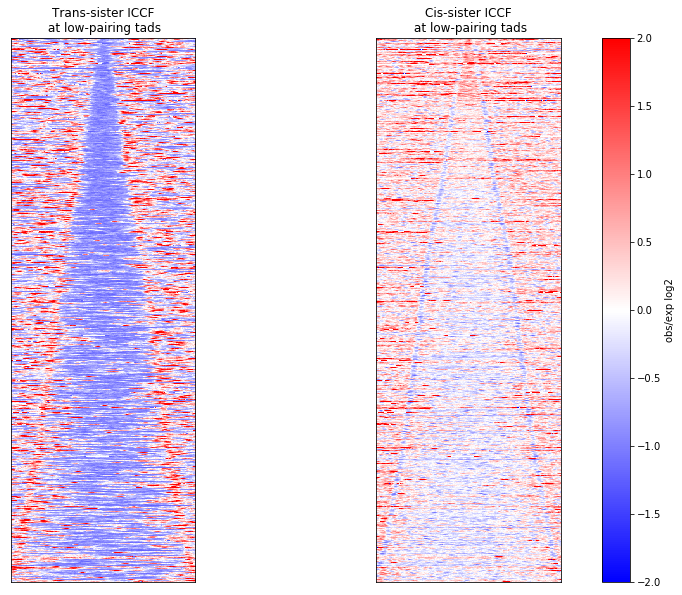

In [38]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictLow["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictLow["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at low-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at low-pairing tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

## Write to file

In [49]:
f.savefig(os.path.join(resultsdir, "Low_pairing_TADs_line_profile.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_TADs_line_profile.pdf"), bbox_inches="tight")

# Calculate H3K27me3 lineprofiles scaled to the same length

## High pairing domains

In [55]:
highList = []
expand = 0.5
bins= 100
for index, row in regionsHighSorted.iterrows():
    chrom = row["chrom"]
    start = row["start"] -  row["size"] * expand
    end = row["end"] +  row["size"] * expand
    h3k27 = bbi.fetch(fileP, chrom, start, end, bins)
    control = bbi.fetch(controlP, chrom, start, end, bins)
    tempResult = h3k27/control
    # replace inf with nan
    tempResult[np.isinf(tempResult)] = np.nan
    highList.append(tempResult)

In [56]:
highStack = np.vstack(highList)

In [57]:
averageHigh = np.nanmean(highStack, axis=0)

In [59]:
plotFrameHigh = pd.DataFrame({"foldCont": averageHigh, "pos": range(bins)})

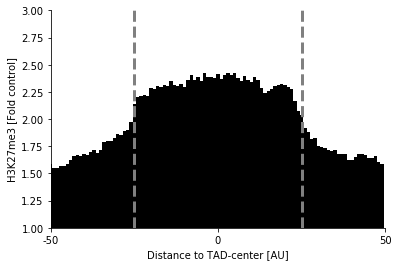

In [60]:
f, ax = plt.subplots()
ax.bar(range(bins), averageHigh, color="black", width=1)
ax.axvline(x=25, color="grey", ls="--", lw=3)
ax.axvline(x=75, color="grey", ls="--", lw=3)
ax.set_ylim(1, 3)
locs, labels = plt.xticks()
plt.xticks([0, 50, 100], [-50, 0, 50])
sbn.despine()
ax.set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax.set_xlim(0, 100)
plt.show()

## Low paring domains

In [61]:
lowList = []
expand = 0.5
bins= 100
for index, row in regionsLowSorted.iterrows():
    chrom = row["chrom"]
    start = row["start"] -  row["size"] * expand
    end = row["end"] +  row["size"] * expand
    h3k27 = bbi.fetch(fileP, chrom, start, end, bins)
    control = bbi.fetch(controlP, chrom, start, end, bins)
    tempResult = h3k27/control
    # replace inf with nan
    tempResult[np.isinf(tempResult)] = np.nan
    lowList.append(tempResult)

In [62]:
lowStack = np.vstack(lowList)

In [63]:
averageLow = np.nanmean(lowStack, axis=0)

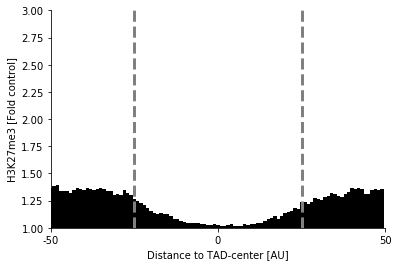

In [64]:
f, ax = plt.subplots()
ax.bar(range(bins), averageLow, color="black", width=1)
ax.axvline(x=25, color="grey", ls="--", lw=3)
ax.axvline(x=75, color="grey", ls="--", lw=3)
ax.set_ylim(1, 3)
locs, labels = plt.xticks()
plt.xticks([0, 50, 100], [-50, 0, 50])
sbn.despine()
ax.set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax.set_xlim(0, 100)
plt.show()

## Both on same plot

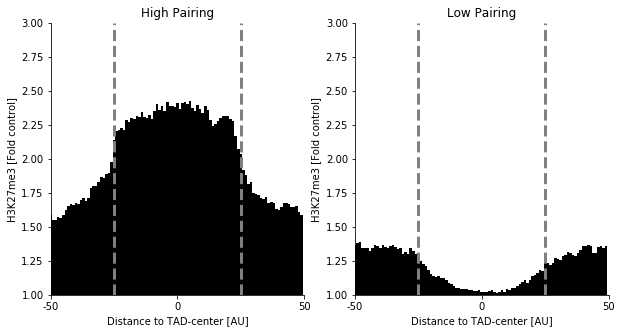

In [80]:
f, ax = plt.subplots(1, 2)
# High
ax[0].bar(range(bins), averageHigh, color="black", width=1)
ax[0].axvline(x=25, color="grey", ls="--", lw=3)
ax[0].axvline(x=75, color="grey", ls="--", lw=3)
plt.sca(ax[0])
ax[0].set_ylim(1, 3)
ax[0].set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax[0].set_xlim(0, 100)
locs, labels = plt.xticks()
plt.xticks([0, 50, 100], [-50, 0, 50])
ax[0].set_title("High Pairing")
# Low
ax[1].bar(range(bins), averageLow, color="black", width=1)
ax[1].axvline(x=25, color="grey", ls="--", lw=3)
ax[1].axvline(x=75, color="grey", ls="--", lw=3)
ax[1].set_ylim(1, 3)
plt.sca(ax[1])
locs, labels = plt.xticks()
plt.xticks([0, 50, 100], [-50, 0, 50])
sbn.despine()
ax[1].set_title("Low Pairing")
ax[1].set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax[1].set_xlim(0, 100)
f.set_size_inches(10, 5)
plt.show()

In [81]:
f.savefig(os.path.join(resultsdir, "Low_pairing_High_pairing_TADs_H3K27me3_average_expand.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_High_pairing_TADs_H3K27me3_average_expand.pdf"), bbox_inches="tight")

## Make cut at TAD-boundary

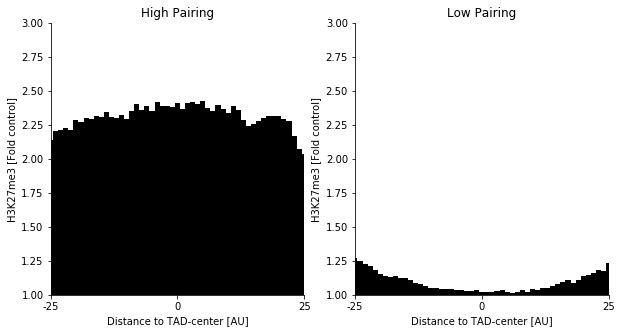

In [78]:
f, ax = plt.subplots(1, 2)
# High
ax[0].set_title("High Pairing")
ax[0].bar(range(bins), averageHigh, color="black", width=1)
plt.sca(ax[0])
ax[0].set_ylim(1, 3)
ax[0].set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax[0].set_xlim(25, 75)
locs, labels = plt.xticks()
plt.xticks([25, 50, 75], [-25, 0, 25])
# Low
ax[1].set_title("Low Pairing")
ax[1].bar(range(bins), averageLow, color="black", width=1)
ax[1].set_ylim(1, 3)
plt.sca(ax[1])
locs, labels = plt.xticks()
plt.xticks([25, 50, 75], [-25, 0, 25])
sbn.despine()
ax[1].set(xlabel="Distance to TAD-center [AU]", ylabel="H3K27me3 [Fold control]")
ax[1].set_xlim(25, 75)
f.set_size_inches(10, 5)
plt.show()

In [79]:
f.savefig(os.path.join(resultsdir, "Low_pairing_High_pairing_TADs_H3K27me3_average.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_High_pairing_TADs_H3K27me3_average.pdf"), bbox_inches="tight")